### Imports & Libraries

In [118]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import itertools
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

True

In [119]:
# seeds
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
if device.type == 'cuda':
    torch.cuda.manual_seed(42)
print(f"Using device: {device}")

Using device: cpu


### Data Loading and Exploration

In [120]:
df = pd.read_csv('data.csv', encoding='utf-8') # https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis
df2 = pd.read_csv('data2.csv', encoding='latin-1') # https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news

df2.columns = ['Sentiment', 'Sentence']
df = pd.concat([df, df2], axis=0)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nSentiment distribution:")
print(df['Sentiment'].value_counts())
print(f"\nMissing values: {df.isnull().sum().sum()}")
df.head()

Dataset shape: (10687, 2)

Columns: ['Sentence', 'Sentiment']

Sentiment distribution:
Sentiment
neutral     6008
positive    3215
negative    1464
Name: count, dtype: int64

Missing values: 0


,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


### Preprocessing

In [121]:
class FinancialSentimentDataset(Dataset):
    def __init__(self, texts, labels, vocab=None, max_length=50, augment=False):
        self.texts = texts
        self.labels = labels
        self.augment = augment
        self.lemmatizer = WordNetLemmatizer()
        
        if vocab is None:
            self.vocab = self.build_vocab(texts, min_freq=3)
        else:
            self.vocab = vocab
            
        self.max_length = max_length
        self.label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
        
    def build_vocab(self, texts, min_freq=3):  # low freq to capture more words # overfitting, increased to 3
        counter = Counter()
        for text in texts:
            tokens = self.preprocess_text(text)
            counter.update(tokens)
        
        vocab = {'<PAD>': 0, '<UNK>': 1}
        idx = 2
        
        for word, freq in counter.items():
            if freq >= min_freq:
                vocab[word] = idx
                idx += 1
                
        return vocab
    
    def preprocess_text(self, text):
        text = text.lower()
        # keep important numbers
        text = re.sub(r'\$\d+(?:\.\d+)?', '<CURRENCY>', text)
        text = re.sub(r'\d+(?:\.\d+)?%', '<PERCENT>', text)
        text = re.sub(r'\b\d+(?:\.\d+)?\b', '<NUMBER>', text)
        # keep tickers (acronyms)
        text = re.sub(r'\b[A-Z]{1,4}(?:\.[A-Z])?\b(?=\s|$)', '<TICKER>', text)
        # keep negations
        text = text.replace("n't", " not").replace("'t", " not")
        # avoid lemmatizing idioms
        tokens = text.split()
        financial_terms = {'bull', 'bear', 'short', 'long', 'rally', 'plunge'}
        tokens = [self.lemmatizer.lemmatize(t) if t not in financial_terms else t for t in tokens]
        return tokens
    
    def text_to_sequence(self, text):
        tokens = self.preprocess_text(text)
        sequence = [self.vocab.get(token, self.vocab['<UNK>']) for token in tokens]
        
        if len(sequence) < self.max_length:
            sequence = sequence + [self.vocab['<PAD>']] * (self.max_length - len(sequence))
        else:
            sequence = sequence[:self.max_length]
            
        return sequence
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.label_map[self.labels[idx]]
        
        sequence = self.text_to_sequence(text)
        
        return torch.tensor(sequence, dtype=torch.long), torch.tensor(label, dtype=torch.long)

### Data Splitting

In [122]:
# split data
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42, stratify=df['Sentiment'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['Sentiment'])

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Training samples: 6412
Validation samples: 2137
Test samples: 2138


In [123]:
# create datasets
train_dataset = FinancialSentimentDataset(
    texts=train_df.iloc[:, 0].values,
    labels=train_df['Sentiment'].values,
    augment=False
)

val_dataset = FinancialSentimentDataset(
    texts=val_df.iloc[:, 0].values,
    labels=val_df['Sentiment'].values,
    vocab=train_dataset.vocab,
    max_length=50
)

test_dataset = FinancialSentimentDataset(
    texts=test_df.iloc[:, 0].values,
    labels=test_df['Sentiment'].values,
    vocab=train_dataset.vocab,
    max_length=50
)
    
print(f"Vocabulary size: {len(train_dataset.vocab)}")

Vocabulary size: 3778


### Imbalanced Data

In [124]:
# handle class weights cuz imbalanced
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
train_labels = [label_map[label.lower()] for label in train_df['Sentiment'].values]

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.FloatTensor(class_weights).to(device)
print(f"Class weights: {class_weights}") # 0.7 -> [2.4343, 0.5929, 1.1080], 0.6 -> 

Class weights: tensor([2.4343, 0.5929, 1.1080])


In [125]:
# dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Model

In [ ]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, n_layers=2, output_dim=3, dropout=0.5):
        super(SentimentLSTM, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            num_layers=n_layers,
            batch_first=True, 
            dropout=dropout,
            bidirectional=True
        )
        
        # assign more weight to specific words in sequence
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim // 2),
            nn.Tanh(),
            nn.Linear(hidden_dim // 2, 1)
        )
        
        self.dropout = nn.Dropout(dropout)
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)

        #self.fc = nn.Linear(hidden_dim * 2, output_dim)
        # features -> output
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, output_dim)
        )
        
    def forward(self, text):
        embedded = self.embedding(text)
        embedded = self.dropout(embedded)
        
        lstm_out, (hidden, cell) = self.lstm(embedded)
        
        aweights = torch.softmax(self.attention(lstm_out), dim=1)
        context = torch.sum(aweights * lstm_out, dim=1)
        
        hidden_concat = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        hidden_concat = hidden_concat + context
        
        # normalization and dropout
        hidden_concat = self.batch_norm(hidden_concat)
        hidden_concat = self.dropout(hidden_concat)
        
        output = self.classifier(hidden_concat)
        return output

In [127]:
# init model
vocab_size = len(train_dataset.vocab)
model = SentimentLSTM(
    vocab_size=vocab_size,
    embedding_dim=192,
    hidden_dim=128,
    output_dim=3,
    n_layers=3,
    dropout=0.33
)
    
model = model.to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Model parameters: 1,879,300


### Train and Eval Functions

In [128]:
def train_epoch(model, dataloader, criterion, optimizer, device, clip_grad=1.0):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(dataloader, desc="Training: "):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        
        # gradient clipping so gradients dont explode
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    avg_loss = total_loss / len(dataloader)
    
    return avg_loss, accuracy

In [129]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating: "):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_predictions) * 100
    
    return avg_loss, accuracy, all_predictions, all_labels

### Training Setup

In [130]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

### Training Loop

In [131]:
num_epochs = 200
train_losses, val_losses = [], []
train_accs, val_accs = [], []
    
best_val_accuracy = 0
best_train_accuracy = 0
patience = 10
patience_counter = 0

for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            # prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        # validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        # get metrics
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, "
          f'Gap: {train_acc - val_acc:.2f}%') # overfitting gap
        
        # early stop metrics
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            best_train_accuracy = train_acc
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_accuracy': val_acc,
                'vocab': train_dataset.vocab,
                'max_length': train_dataset.max_length,
                'model_config': {
                    'vocab_size': vocab_size,
                    'embedding_dim': 256,
                    'hidden_dim': 128,
                    'output_dim': 3,
                    'n_layers': 3,
                    'dropout': 0.3
                }
            }, 'best_model.pth')
        else:
            patience_counter += 1
        # early stop check
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

print(f"\nBest validation accuracy: {best_val_accuracy:.2f}%")
print(f"Best training accuracy: {best_train_accuracy:.2f}%")

Epoch 1/200: 100%|██████████| 101/101 [00:15<00:00,  6.47it/s]


Epoch [1/200], Train Loss: 1.0182, Train Acc: 50.66%, Val Loss: 0.8659, Val Acc: 63.92%, Gap: -13.27%


Epoch 2/200: 100%|██████████| 101/101 [00:14<00:00,  6.88it/s]


Epoch [2/200], Train Loss: 0.8191, Train Acc: 64.32%, Val Loss: 0.8489, Val Acc: 70.57%, Gap: -6.25%


Epoch 3/200: 100%|██████████| 101/101 [00:15<00:00,  6.43it/s]


Epoch [3/200], Train Loss: 0.7166, Train Acc: 68.79%, Val Loss: 0.6842, Val Acc: 74.40%, Gap: -5.61%


Epoch 4/200: 100%|██████████| 101/101 [00:16<00:00,  6.12it/s]


Epoch [4/200], Train Loss: 0.5831, Train Acc: 74.89%, Val Loss: 0.7000, Val Acc: 66.07%, Gap: 8.82%


Epoch 5/200: 100%|██████████| 101/101 [00:17<00:00,  5.74it/s]


Epoch [5/200], Train Loss: 0.5068, Train Acc: 77.39%, Val Loss: 0.6224, Val Acc: 75.39%, Gap: 2.00%


Epoch 6/200: 100%|██████████| 101/101 [00:15<00:00,  6.32it/s]


Epoch [6/200], Train Loss: 0.4469, Train Acc: 79.88%, Val Loss: 0.6852, Val Acc: 73.98%, Gap: 5.90%


Epoch 7/200: 100%|██████████| 101/101 [00:15<00:00,  6.54it/s]


Epoch [7/200], Train Loss: 0.3947, Train Acc: 83.00%, Val Loss: 0.7333, Val Acc: 80.53%, Gap: 2.47%


Epoch 8/200: 100%|██████████| 101/101 [00:16<00:00,  6.25it/s]


Epoch [8/200], Train Loss: 0.3477, Train Acc: 84.87%, Val Loss: 0.8685, Val Acc: 78.66%, Gap: 6.21%


Epoch 9/200: 100%|██████████| 101/101 [00:16<00:00,  6.24it/s]


Epoch [9/200], Train Loss: 0.3264, Train Acc: 85.84%, Val Loss: 0.9126, Val Acc: 79.78%, Gap: 6.05%


Epoch 10/200: 100%|██████████| 101/101 [00:15<00:00,  6.48it/s]


Epoch [10/200], Train Loss: 0.2814, Train Acc: 87.43%, Val Loss: 0.8979, Val Acc: 81.24%, Gap: 6.19%


Epoch 11/200: 100%|██████████| 101/101 [00:15<00:00,  6.44it/s]


Epoch [11/200], Train Loss: 0.2743, Train Acc: 88.24%, Val Loss: 0.8657, Val Acc: 75.43%, Gap: 12.81%


Epoch 12/200: 100%|██████████| 101/101 [00:17<00:00,  5.71it/s]


Epoch [12/200], Train Loss: 0.2670, Train Acc: 88.77%, Val Loss: 0.8336, Val Acc: 80.35%, Gap: 8.42%


Epoch 13/200: 100%|██████████| 101/101 [00:16<00:00,  6.23it/s]


Epoch [13/200], Train Loss: 0.2322, Train Acc: 90.00%, Val Loss: 0.9208, Val Acc: 78.43%, Gap: 11.58%


Epoch 14/200: 100%|██████████| 101/101 [00:16<00:00,  6.09it/s]


Epoch [14/200], Train Loss: 0.2194, Train Acc: 90.00%, Val Loss: 0.9246, Val Acc: 80.81%, Gap: 9.19%


Epoch 15/200: 100%|██████████| 101/101 [00:15<00:00,  6.36it/s]


Epoch [15/200], Train Loss: 0.2171, Train Acc: 90.55%, Val Loss: 0.9787, Val Acc: 81.14%, Gap: 9.41%


Epoch 16/200: 100%|██████████| 101/101 [00:16<00:00,  6.26it/s]


Epoch [16/200], Train Loss: 0.1981, Train Acc: 91.61%, Val Loss: 0.9211, Val Acc: 81.42%, Gap: 10.19%


Epoch 17/200: 100%|██████████| 101/101 [00:15<00:00,  6.35it/s]


Epoch [17/200], Train Loss: 0.1839, Train Acc: 92.20%, Val Loss: 0.9721, Val Acc: 81.19%, Gap: 11.01%


Epoch 18/200: 100%|██████████| 101/101 [00:16<00:00,  6.14it/s]


Epoch [18/200], Train Loss: 0.1753, Train Acc: 92.61%, Val Loss: 1.1875, Val Acc: 81.38%, Gap: 11.23%


Epoch 19/200: 100%|██████████| 101/101 [00:15<00:00,  6.47it/s]


Epoch [19/200], Train Loss: 0.1793, Train Acc: 92.58%, Val Loss: 1.2470, Val Acc: 81.75%, Gap: 10.83%


Epoch 20/200: 100%|██████████| 101/101 [00:16<00:00,  6.04it/s]


Epoch [20/200], Train Loss: 0.1616, Train Acc: 92.78%, Val Loss: 1.0965, Val Acc: 81.00%, Gap: 11.78%


Epoch 21/200: 100%|██████████| 101/101 [00:17<00:00,  5.76it/s]


Epoch [21/200], Train Loss: 0.1736, Train Acc: 92.94%, Val Loss: 1.2991, Val Acc: 81.75%, Gap: 11.19%


Epoch 22/200: 100%|██████████| 101/101 [00:16<00:00,  6.06it/s]


Epoch [22/200], Train Loss: 0.1530, Train Acc: 93.34%, Val Loss: 1.2075, Val Acc: 81.66%, Gap: 11.68%


Epoch 23/200: 100%|██████████| 101/101 [00:15<00:00,  6.32it/s]


Epoch [23/200], Train Loss: 0.1662, Train Acc: 92.89%, Val Loss: 1.1179, Val Acc: 81.56%, Gap: 11.33%


Epoch 24/200: 100%|██████████| 101/101 [00:16<00:00,  6.18it/s]


Epoch [24/200], Train Loss: 0.1559, Train Acc: 93.08%, Val Loss: 1.3341, Val Acc: 82.26%, Gap: 10.81%


Epoch 25/200: 100%|██████████| 101/101 [00:15<00:00,  6.50it/s]


Epoch [25/200], Train Loss: 0.1422, Train Acc: 93.70%, Val Loss: 1.3466, Val Acc: 82.17%, Gap: 11.53%


Epoch 26/200: 100%|██████████| 101/101 [00:17<00:00,  5.68it/s]


Epoch [26/200], Train Loss: 0.1407, Train Acc: 93.79%, Val Loss: 1.3325, Val Acc: 81.47%, Gap: 12.32%


Epoch 27/200: 100%|██████████| 101/101 [00:15<00:00,  6.32it/s]


Epoch [27/200], Train Loss: 0.1351, Train Acc: 93.96%, Val Loss: 1.3191, Val Acc: 81.66%, Gap: 12.31%


Epoch 28/200: 100%|██████████| 101/101 [00:16<00:00,  6.12it/s]


Epoch [28/200], Train Loss: 0.1324, Train Acc: 94.07%, Val Loss: 1.2891, Val Acc: 81.75%, Gap: 12.32%


Epoch 29/200: 100%|██████████| 101/101 [00:15<00:00,  6.64it/s]


Epoch [29/200], Train Loss: 0.1325, Train Acc: 94.06%, Val Loss: 1.5809, Val Acc: 81.28%, Gap: 12.78%


Epoch 30/200: 100%|██████████| 101/101 [00:15<00:00,  6.47it/s]


Epoch [30/200], Train Loss: 0.1340, Train Acc: 94.07%, Val Loss: 1.2821, Val Acc: 82.41%, Gap: 11.67%


Epoch 31/200: 100%|██████████| 101/101 [00:16<00:00,  6.09it/s]


Epoch [31/200], Train Loss: 0.1402, Train Acc: 94.03%, Val Loss: 1.4388, Val Acc: 81.56%, Gap: 12.46%


Epoch 32/200: 100%|██████████| 101/101 [00:16<00:00,  6.00it/s]


Epoch [32/200], Train Loss: 0.1391, Train Acc: 94.14%, Val Loss: 1.2670, Val Acc: 81.24%, Gap: 12.90%


Epoch 33/200: 100%|██████████| 101/101 [00:16<00:00,  5.97it/s]


Epoch [33/200], Train Loss: 0.1355, Train Acc: 94.23%, Val Loss: 1.3942, Val Acc: 81.61%, Gap: 12.62%


Epoch 34/200: 100%|██████████| 101/101 [00:15<00:00,  6.45it/s]


Epoch [34/200], Train Loss: 0.1297, Train Acc: 94.34%, Val Loss: 1.2832, Val Acc: 81.70%, Gap: 12.64%


Epoch 35/200: 100%|██████████| 101/101 [00:15<00:00,  6.55it/s]


Epoch [35/200], Train Loss: 0.1209, Train Acc: 94.60%, Val Loss: 1.5291, Val Acc: 82.03%, Gap: 12.57%


Epoch 36/200: 100%|██████████| 101/101 [00:15<00:00,  6.45it/s]


Epoch [36/200], Train Loss: 0.1243, Train Acc: 94.45%, Val Loss: 1.5085, Val Acc: 81.84%, Gap: 12.60%


Epoch 37/200: 100%|██████████| 101/101 [00:15<00:00,  6.47it/s]


Epoch [37/200], Train Loss: 0.1303, Train Acc: 94.56%, Val Loss: 1.5467, Val Acc: 82.03%, Gap: 12.53%


Epoch 38/200: 100%|██████████| 101/101 [00:15<00:00,  6.50it/s]


Epoch [38/200], Train Loss: 0.1310, Train Acc: 94.65%, Val Loss: 1.5729, Val Acc: 81.56%, Gap: 13.09%


Epoch 39/200: 100%|██████████| 101/101 [00:16<00:00,  6.21it/s]


Epoch [39/200], Train Loss: 0.1084, Train Acc: 94.76%, Val Loss: 1.5591, Val Acc: 81.70%, Gap: 13.06%


Epoch 40/200: 100%|██████████| 101/101 [00:15<00:00,  6.58it/s]


Epoch [40/200], Train Loss: 0.1296, Train Acc: 94.35%, Val Loss: 1.4422, Val Acc: 81.47%, Gap: 12.88%
Early stopping at epoch 40

Best validation accuracy: 82.41%
Best training accuracy: 94.07%


### Evaluation

In [132]:
checkpoint = torch.load('best_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

# eval on test set
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion, device)
    
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print("\nClassification Report:")
class_names = ['negative', 'neutral', 'positive']
print(classification_report(test_labels, test_preds, target_names=class_names))

Evaluating: 100%|██████████| 34/34 [00:01<00:00, 21.89it/s]

Test Loss: 1.2559
Test Accuracy: 81.95%

Classification Report:
              precision    recall  f1-score   support

    negative       0.58      0.74      0.65       293
     neutral       0.91      0.83      0.87      1202
    positive       0.81      0.84      0.82       643

    accuracy                           0.82      2138
   macro avg       0.77      0.80      0.78      2138
weighted avg       0.83      0.82      0.82      2138



### Tuner

In [ ]:
def hyperparameter_search(train_loader, val_loader, train_dataset, device, class_weights):
    # hyperparameter grid
    param_grid = {
        'embedding_dim': [128, 192, 256], # usually favours 192
        'hidden_dim': [64, 128, 192], # 128 almost always chosen
        'n_layers': [3], # no more or it tunes for hours
        'dropout': [0.3, 0.5], # usually favours 0.5
        'lr': [0.001], # 0.001 almost always chosen
        'batch_size': [64] # 64 almost always chosen
    }
    
    # get all combos
    keys = param_grid.keys()
    combinations = [dict(zip(keys, v)) for v in itertools.product(*param_grid.values())]
    
    print(f"Testing {len(combinations)} combos...")
    
    results = []
    best_val_acc = 0
    best_params = None
    
    for i, params in enumerate(combinations, 1):
        print(f"\nConfiguration {i}/{len(combinations)}; Parameters: {params}")
        
        # fix data loaders if batch size changed
        if params['batch_size'] != 32:
            current_train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
            current_val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)
        else:
            current_train_loader = train_loader
            current_val_loader = val_loader
            
        # init model with current hyperparameters
        model = SentimentLSTM(
            vocab_size=len(train_dataset.vocab),
            embedding_dim=params['embedding_dim'],
            hidden_dim=params['hidden_dim'],
            output_dim=3,
            n_layers=params['n_layers'],
            dropout=params['dropout']
        ).to(device)
            
        # init optimizer and criterion
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.AdamW(model.parameters(), lr=params['lr'], weight_decay=0.01)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
            
        # train
        max_epochs = 15
        patience = 2
        patience_counter = 0
        best_val_acc_config = 0
            
        for epoch in range(max_epochs):
            train_loss, train_acc = train_epoch(model, current_train_loader, criterion, optimizer, device)
            val_loss, val_acc, _, _ = evaluate(model, current_val_loader, criterion, device)
                
            scheduler.step(val_loss)
            
            if val_acc > best_val_acc_config:
                best_val_acc_config = val_acc
                patience_counter = 0
            else:
                patience_counter += 1
                
            if patience_counter >= patience:
                break
            
        # keep results
        result = {
            'params': params.copy(),
            'val_accuracy': best_val_acc_config,
            'final_epoch': epoch + 1
        }
        results.append(result)
            
        print(f"Best Val Accuracy: {best_val_acc_config:.2f}%")
            
        # update best
        if best_val_acc_config > best_val_acc:
            best_val_acc = best_val_acc_config
            best_params = params.copy()
            
        # wipe
        del model, optimizer, criterion, scheduler
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    print("\nBEST CONFIGURATION")
    print(f"Validation Accuracy: {best_val_acc:.2f}%")
    print(f"Parameters: {best_params}")
    
    return best_params, results

In [134]:
# run hyperparameter search
best_config, all_results = hyperparameter_search(
    train_loader, val_loader, train_dataset, device, class_weights
)

# dataloaders with best batch size
best_train_loader = DataLoader(train_dataset, batch_size=best_config['batch_size'], shuffle=True)
best_val_loader = DataLoader(val_dataset, batch_size=best_config['batch_size'], shuffle=False)
best_test_loader = DataLoader(test_dataset, batch_size=best_config['batch_size'], shuffle=False)

# init model using best cfg
best_model = SentimentLSTM(
    vocab_size=len(train_dataset.vocab),
    embedding_dim=best_config['embedding_dim'],
    hidden_dim=best_config['hidden_dim'],
    output_dim=3,
    n_layers=best_config['n_layers'],
    dropout=best_config['dropout']
).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(best_model.parameters(), lr=best_config['lr'], weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

Testing 8 combos...

Configuration 1/8; Parameters: {'embedding_dim': 128, 'hidden_dim': 128, 'n_layers': 3, 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 64}


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 26.01it/s]


Best Val Accuracy: 76.23%

Configuration 2/8; Parameters: {'embedding_dim': 128, 'hidden_dim': 128, 'n_layers': 3, 'dropout': 0.3, 'lr': 0.001, 'batch_size': 64}


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 27.04it/s]


Best Val Accuracy: 74.08%

Configuration 3/8; Parameters: {'embedding_dim': 128, 'hidden_dim': 128, 'n_layers': 3, 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 64}


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 19.84it/s]


Best Val Accuracy: 72.77%

Configuration 4/8; Parameters: {'embedding_dim': 128, 'hidden_dim': 128, 'n_layers': 3, 'dropout': 0.5, 'lr': 0.001, 'batch_size': 64}


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 26.08it/s]


Best Val Accuracy: 78.19%

Configuration 5/8; Parameters: {'embedding_dim': 192, 'hidden_dim': 128, 'n_layers': 3, 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 64}


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 20.70it/s]


Best Val Accuracy: 80.49%

Configuration 6/8; Parameters: {'embedding_dim': 192, 'hidden_dim': 128, 'n_layers': 3, 'dropout': 0.3, 'lr': 0.001, 'batch_size': 64}


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 23.61it/s]


Best Val Accuracy: 81.52%

Configuration 7/8; Parameters: {'embedding_dim': 192, 'hidden_dim': 128, 'n_layers': 3, 'dropout': 0.5, 'lr': 0.0005, 'batch_size': 64}


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 24.94it/s]


Best Val Accuracy: 77.59%

Configuration 8/8; Parameters: {'embedding_dim': 192, 'hidden_dim': 128, 'n_layers': 3, 'dropout': 0.5, 'lr': 0.001, 'batch_size': 64}


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 25.66it/s]

Best Val Accuracy: 79.41%

BEST CONFIGURATION
Validation Accuracy: 81.52%
Parameters: {'embedding_dim': 192, 'hidden_dim': 128, 'n_layers': 3, 'dropout': 0.3, 'lr': 0.001, 'batch_size': 64}


In [135]:
# sort results by val accuracy
all_results.sort(key=lambda x: x['val_accuracy'], reverse=True)

for i, result in enumerate(all_results[:3], 1):
        print(f"\n{i}. Val Accuracy: {result['val_accuracy']:.2f}%")
        print(f"   Params: {result['params']}")


1. Val Accuracy: 81.52%
   Params: {'embedding_dim': 192, 'hidden_dim': 128, 'n_layers': 3, 'dropout': 0.3, 'lr': 0.001, 'batch_size': 64}

2. Val Accuracy: 80.49%
   Params: {'embedding_dim': 192, 'hidden_dim': 128, 'n_layers': 3, 'dropout': 0.3, 'lr': 0.0005, 'batch_size': 64}

3. Val Accuracy: 79.41%
   Params: {'embedding_dim': 192, 'hidden_dim': 128, 'n_layers': 3, 'dropout': 0.5, 'lr': 0.001, 'batch_size': 64}


In [136]:
# history for tuned model
history = {
    'epoch': [],
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'learning_rate': [],
    'best_val_acc': [],
    'best_train_acc': []
}

# train with best config
num_epochs = 200
best_val_accuracy = 0
best_train_accuracy = 0
patience = 10
patience_counter = 0

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(best_model, best_train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = evaluate(best_model, best_val_loader, criterion, device)
    
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    if val_acc > best_val_accuracy and train_acc > best_train_accuracy:
        best_val_accuracy = val_acc
        best_train_accuracy = train_acc
        patience_counter = 0
        torch.save({
            'model_state_dict': best_model.state_dict(),
            'epoch': epoch + 1,
            'val_accuracy': val_acc,
            'train_accuracy': train_acc,
            'val_loss': val_loss,
            'train_loss': train_loss,
            'vocab': train_dataset.vocab,
            'max_length': train_dataset.max_length,
            'model_config': best_config
        }, 'best_tuned_model.pth')
    else:
        patience_counter += 1
    
    # tuned history
    history['epoch'].append(epoch + 1)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['learning_rate'].append(current_lr)
    history['best_val_acc'].append(best_val_accuracy)
    history['best_train_acc'].append(best_train_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
    
    if patience_counter >= patience:
        break

Evaluating: 100%|██████████| 34/34 [00:01<00:00, 24.64it/s]


Epoch [1/200], Train Acc: 51.82%, Val Acc: 60.69%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 26.64it/s]


Epoch [2/200], Train Acc: 63.15%, Val Acc: 60.04%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 22.68it/s]


Epoch [3/200], Train Acc: 69.79%, Val Acc: 72.34%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 25.97it/s]


Epoch [4/200], Train Acc: 75.42%, Val Acc: 75.01%


Evaluating: 100%|██████████| 34/34 [00:02<00:00, 16.86it/s]


Epoch [5/200], Train Acc: 78.84%, Val Acc: 72.77%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 19.27it/s]


Epoch [6/200], Train Acc: 81.78%, Val Acc: 76.51%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 27.13it/s]


Epoch [7/200], Train Acc: 84.17%, Val Acc: 76.23%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 23.30it/s]


Epoch [8/200], Train Acc: 85.42%, Val Acc: 78.33%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 25.28it/s]


Epoch [9/200], Train Acc: 87.34%, Val Acc: 79.83%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 21.20it/s]


Epoch [10/200], Train Acc: 90.21%, Val Acc: 80.49%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 19.46it/s]


Epoch [11/200], Train Acc: 90.58%, Val Acc: 80.63%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 25.98it/s]


Epoch [12/200], Train Acc: 91.03%, Val Acc: 80.86%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 21.13it/s]


Epoch [13/200], Train Acc: 92.25%, Val Acc: 81.19%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 25.39it/s]


Epoch [14/200], Train Acc: 92.64%, Val Acc: 80.86%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 27.24it/s]


Epoch [15/200], Train Acc: 93.37%, Val Acc: 81.52%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 18.77it/s]


Epoch [16/200], Train Acc: 93.29%, Val Acc: 81.14%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 19.23it/s]


Epoch [17/200], Train Acc: 93.53%, Val Acc: 81.70%


Evaluating: 100%|██████████| 34/34 [00:02<00:00, 13.99it/s]


Epoch [18/200], Train Acc: 93.50%, Val Acc: 81.09%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 20.95it/s]


Epoch [19/200], Train Acc: 93.89%, Val Acc: 81.47%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 27.95it/s]


Epoch [20/200], Train Acc: 94.09%, Val Acc: 81.75%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 26.16it/s]


Epoch [21/200], Train Acc: 94.20%, Val Acc: 81.38%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 27.15it/s]


Epoch [22/200], Train Acc: 93.87%, Val Acc: 81.47%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 27.82it/s]


Epoch [23/200], Train Acc: 94.23%, Val Acc: 81.52%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 25.98it/s]


Epoch [24/200], Train Acc: 94.14%, Val Acc: 81.84%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 27.18it/s]


Epoch [25/200], Train Acc: 94.09%, Val Acc: 81.70%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 26.70it/s]


Epoch [26/200], Train Acc: 93.90%, Val Acc: 81.80%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 18.87it/s]


Epoch [27/200], Train Acc: 94.23%, Val Acc: 81.75%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 23.75it/s]


Epoch [28/200], Train Acc: 93.98%, Val Acc: 81.75%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 25.90it/s]


Epoch [29/200], Train Acc: 93.93%, Val Acc: 81.70%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 24.91it/s]


Epoch [30/200], Train Acc: 94.15%, Val Acc: 81.80%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 25.91it/s]


Epoch [31/200], Train Acc: 94.21%, Val Acc: 81.70%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 28.32it/s]


Epoch [32/200], Train Acc: 94.17%, Val Acc: 81.89%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 21.80it/s]


Epoch [33/200], Train Acc: 94.35%, Val Acc: 81.70%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 22.31it/s]


Epoch [34/200], Train Acc: 94.28%, Val Acc: 81.89%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 24.98it/s]


Epoch [35/200], Train Acc: 94.35%, Val Acc: 81.70%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 23.87it/s]


Epoch [36/200], Train Acc: 94.20%, Val Acc: 81.75%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 26.22it/s]


Epoch [37/200], Train Acc: 94.14%, Val Acc: 81.75%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 22.19it/s]


Epoch [38/200], Train Acc: 94.31%, Val Acc: 81.80%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 26.31it/s]


Epoch [39/200], Train Acc: 94.12%, Val Acc: 81.70%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 26.08it/s]


Epoch [40/200], Train Acc: 94.15%, Val Acc: 81.80%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 24.85it/s]


Epoch [41/200], Train Acc: 94.32%, Val Acc: 81.75%


Evaluating: 100%|██████████| 34/34 [00:01<00:00, 22.69it/s]

Epoch [42/200], Train Acc: 94.28%, Val Acc: 81.66%


In [137]:
# eval with tuned model
checkpoint = torch.load('best_tuned_model.pth', map_location=device)
best_model.load_state_dict(checkpoint['model_state_dict'])

test_loss, test_acc, test_preds, test_labels = evaluate(best_model, best_test_loader, criterion, device)
print(f"Final Test Acc: {test_acc:.2f}%")
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names))

Evaluating: 100%|██████████| 34/34 [00:01<00:00, 17.24it/s]

Final Test Acc: 82.55%

Classification Report:
              precision    recall  f1-score   support

    negative       0.59      0.72      0.65       293
     neutral       0.90      0.84      0.87      1202
    positive       0.83      0.84      0.83       643

    accuracy                           0.83      2138
   macro avg       0.77      0.80      0.78      2138
weighted avg       0.84      0.83      0.83      2138



### Visualizations

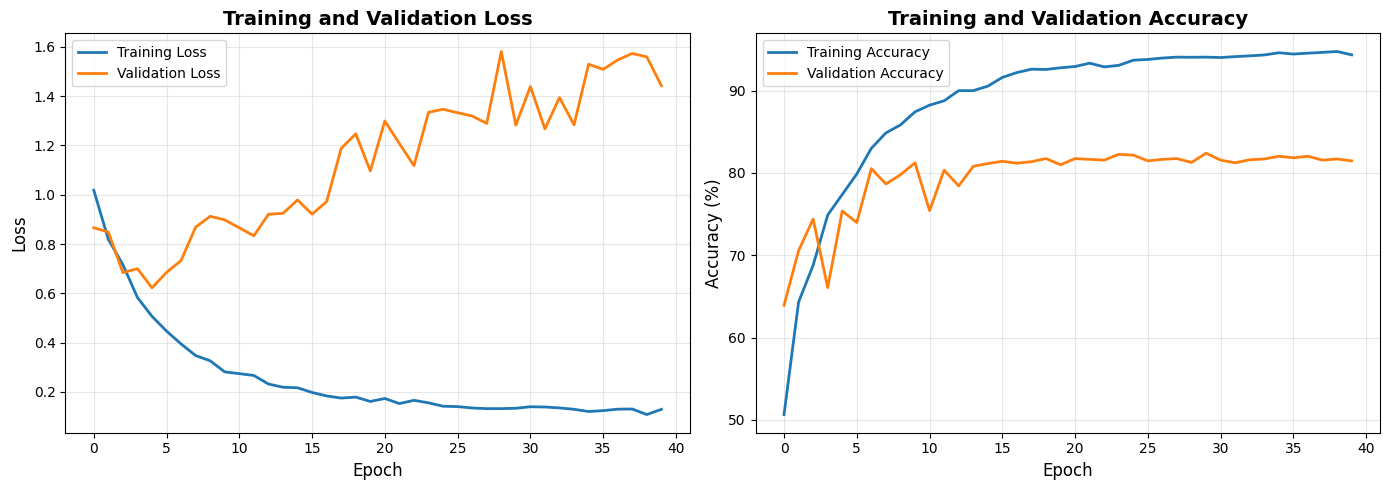

In [138]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
# loss
axes[0].plot(train_losses, label='Training Loss', linewidth=2)
axes[0].plot(val_losses, label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
    
# accuracy
axes[1].plot(train_accs, label='Training Accuracy', linewidth=2)
axes[1].plot(val_accs, label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
    
plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

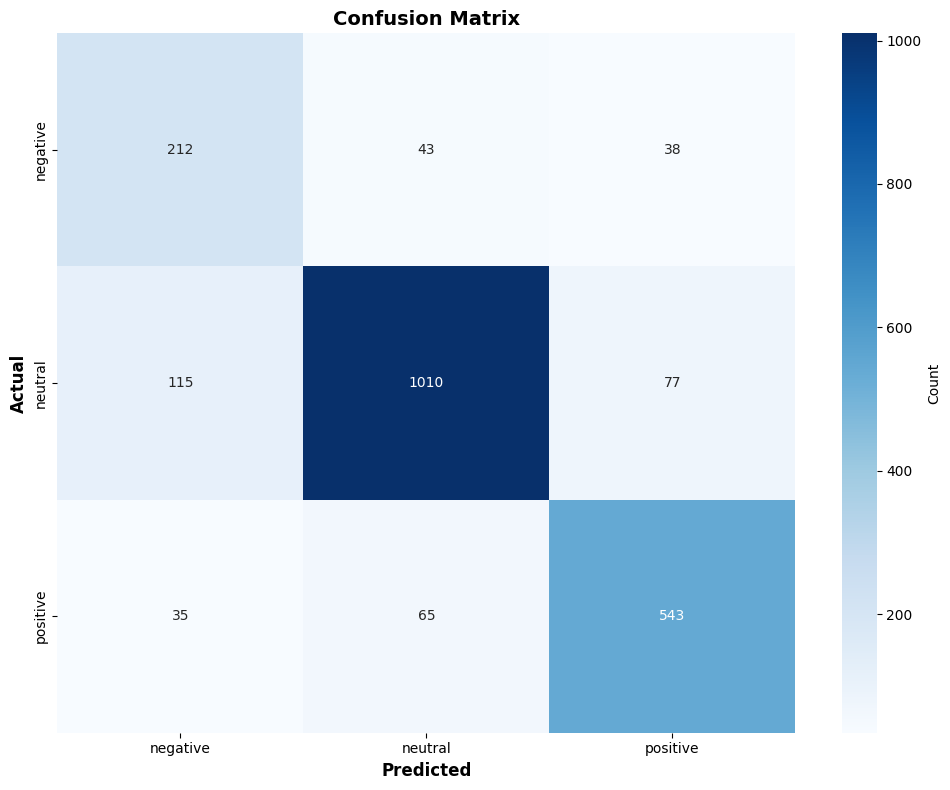

In [139]:
cm = confusion_matrix(test_labels, test_preds)
    
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [140]:
# make history df and group by epoch
history_df = pd.DataFrame(history)
if len(history_df['epoch'].unique()) < len(history_df):
    history_df = history_df.groupby('epoch').mean().reset_index()
history_df.head()

,epoch,train_loss,train_acc,val_loss,val_acc,learning_rate,best_val_acc,best_train_acc
0,1,1.010253,51.824704,0.904915,60.692560,0.001,60.692560,51.824704
1,2,0.835682,63.147224,0.800880,60.037436,0.001,60.692560,51.824704
2,3,0.689112,69.791017,0.686685,72.344408,0.001,72.344408,69.791017
3,4,0.554791,75.421085,0.684873,75.011699,0.001,75.011699,75.421085
4,5,0.491132,78.836556,0.672384,72.765559,0.001,75.011699,75.421085


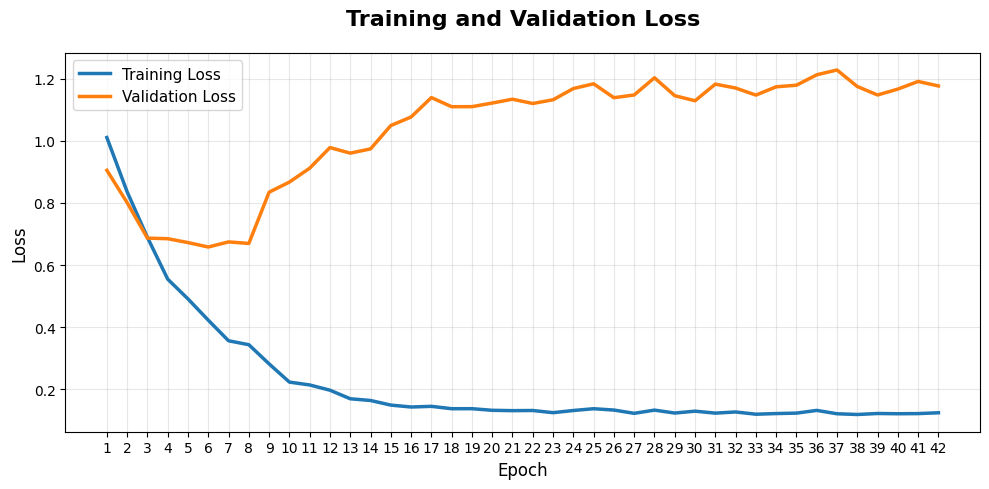

In [146]:
plt.figure(figsize=(10, 5))
plt.plot(history_df['epoch'], history_df['train_loss'], label='Training Loss', linewidth=2.5)
plt.plot(history_df['epoch'], history_df['val_loss'], label='Validation Loss', linewidth=2.5)
plt.title('Training and Validation Loss', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(history_df['epoch'])
plt.tight_layout()
plt.savefig('tuned_loss.png', dpi=300, bbox_inches='tight')
plt.show()

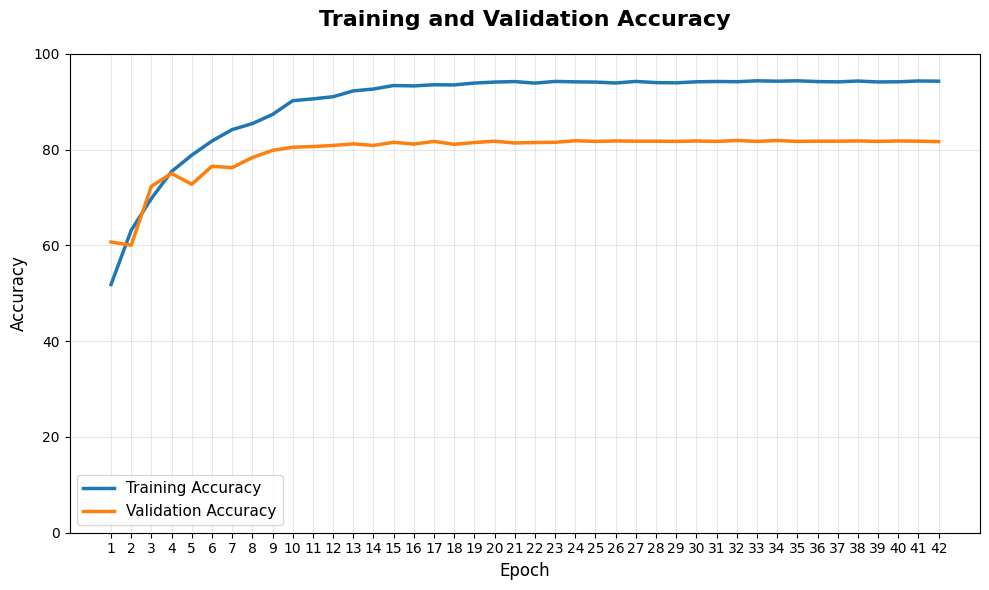

In [147]:
plt.figure(figsize=(10, 6))
plt.plot(history_df['epoch'], history_df['train_acc'], label='Training Accuracy', linewidth=2.5)
plt.plot(history_df['epoch'], history_df['val_acc'], label='Validation Accuracy', linewidth=2.5)
plt.title('Training and Validation Accuracy', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(history_df['epoch'])
plt.ylim(0, 100)
plt.tight_layout()
plt.savefig('tuned_acc.png', dpi=300, bbox_inches='tight')
plt.show()

### Headline Classification

In [143]:
def predict_sentiment(text, model, dataset, device):
    model.eval()
    
    # preprocess + convert to sequence
    sequence = dataset.text_to_sequence(text)
    sequence_tensor = torch.tensor([sequence], dtype=torch.long).to(device)
    
    # get pred
    with torch.no_grad():
        output = model(sequence_tensor)
        probabilities = torch.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_class].item()
    
    # map pred to label
    label_map_reverse = {0: 'negative', 1: 'neutral', 2: 'positive'}
    sentiment = label_map_reverse[predicted_class]
    
    return {
        'sentiment': sentiment,
        'confidence': confidence * 100,
        'probabilities': {
            'negative': probabilities[0][0].item() * 100,
            'neutral': probabilities[0][1].item() * 100,
            'positive': probabilities[0][2].item() * 100
        }
    }

def display_prediction(result):
    sentiment = result['sentiment']
    confidence = result['confidence']
    probs = result['probabilities']
    
    print(f" PREDICTION: {sentiment.upper()} (Confidence: {confidence:.2f}%)")
    print("\nProbability Distribution:")
    print(f"  Negative: {probs['negative']:6.2f}%  {'█' * int(probs['negative']/2)}")
    print(f"  Neutral:  {probs['neutral']:6.2f}%  {'█' * int(probs['neutral']/2)}")
    print(f"  Positive: {probs['positive']:6.2f}%  {'█' * int(probs['positive']/2)}")

In [144]:
# test single headline
headline = "U.S. job openings fall to 6.5 million, fewest since 2020, as labor market remains sluggish"

result = predict_sentiment(headline, model, train_dataset, device)
print(f"\nInput: '{headline}'")
display_prediction(result)


Input: 'U.S. job openings fall to 6.5 million, fewest since 2020, as labor market remains sluggish'
 PREDICTION: NEGATIVE (Confidence: 95.79%)

Probability Distribution:
  Negative:  95.79%  ███████████████████████████████████████████████
  Neutral:    4.07%  ██
  Positive:   0.14%  


In [145]:
# test multiple headlines
test_headlines = [
    "Canada to spend up to $200B on wind, solar, and energy storage",
    "A green morning.",
    "The Trump administration canceled 145 enforcement actions against 153 corporations facing accountability measures for alleged lawbreaking",
    "More Americans will die than be born in 2030, CBO has predicted.",
    "\"You may be able to use buy now, pay later for rent,\" per CNBC",
    "\"Microsoft, $MSFT, CEO warns that we must 'do something useful' with AI or they'll lose 'social permission' to burn electricity on it,\" per PCGamer."
]

print("BATCH PREDICTIONS")

for i, headline in enumerate(test_headlines, 1):
    result = predict_sentiment(headline, model, train_dataset, device)
    print(f"\n[{i}] {headline}")
    display_prediction(result)

BATCH PREDICTIONS

[1] Canada to spend up to $200B on wind, solar, and energy storage
 PREDICTION: POSITIVE (Confidence: 100.00%)

Probability Distribution:
  Negative:   0.00%  
  Neutral:    0.00%  
  Positive: 100.00%  █████████████████████████████████████████████████

[2] A green morning.
 PREDICTION: POSITIVE (Confidence: 99.97%)

Probability Distribution:
  Negative:   0.01%  
  Neutral:    0.02%  
  Positive:  99.97%  █████████████████████████████████████████████████

[3] The Trump administration canceled 145 enforcement actions against 153 corporations facing accountability measures for alleged lawbreaking
 PREDICTION: NEGATIVE (Confidence: 96.99%)

Probability Distribution:
  Negative:  96.99%  ████████████████████████████████████████████████
  Neutral:    0.14%  
  Positive:   2.87%  █

[4] More Americans will die than be born in 2030, CBO has predicted.
 PREDICTION: NEGATIVE (Confidence: 99.56%)

Probability Distribution:
  Negative:  99.56%  ████████████████████████████████